In [1]:
import matplotlib
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set_style('darkgrid') 
matplotlib.rcParams['figure.figsize'] = (30,30)
pd.set_option('display.max_columns', None)

## Importing `.csv`

In [2]:
df = pd.read_csv('df.csv')
df.set_index('FIPS');

# Dataset exploration

## Visual exploration

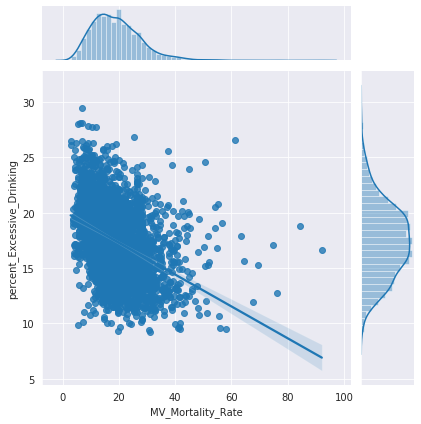

In [3]:
sns.jointplot('MV_Mortality_Rate','percent_Excessive_Drinking', data=df, kind='reg');

- Create graph matrix with [features]

# Feature selection

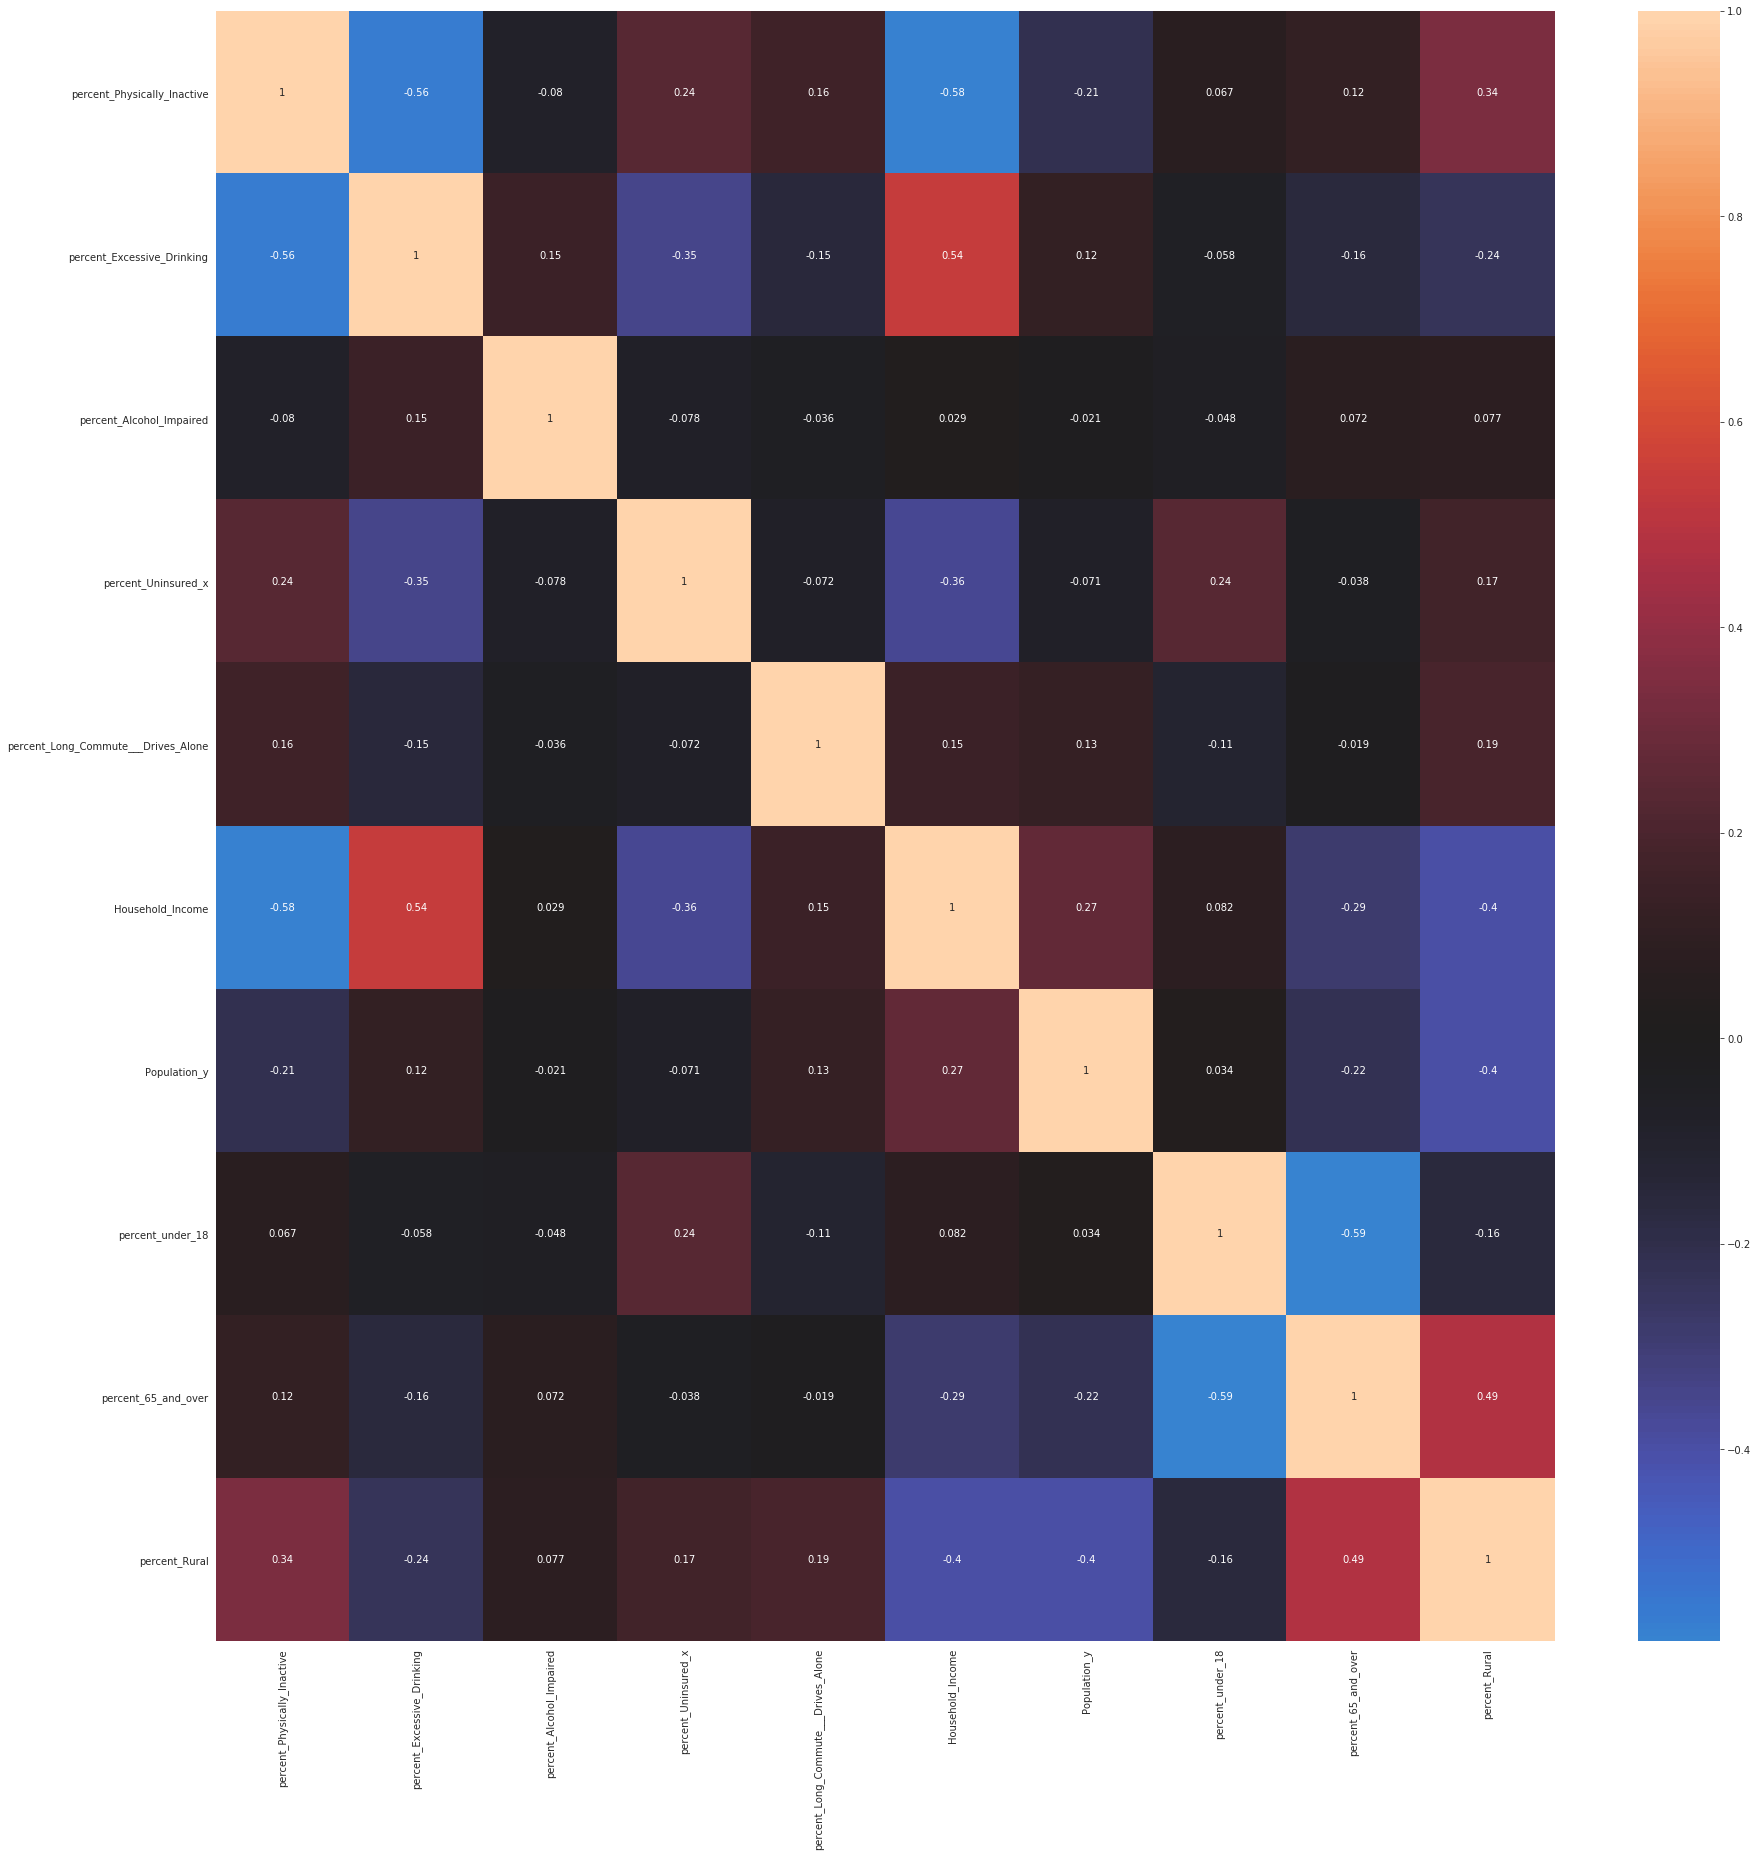

In [4]:
# Original feature list, narrowed down based on vif
# features = ['MV_Mortality_Rate',
#             'Years_of_Potential_Life_Lost_Rate',
#             'percent_Physically_Inactive',
#             'percent_Excessive_Drinking',
#             'percent_Alcohol_Impaired',
#             'percent_Uninsured_x',
#             'Average_Daily_PM25',
#             'percent_Drive_Alone',
#             'percent_Long_Commute___Drives_Alone',
#             'percent_Insufficient_Sleep',
#             'Household_Income',
#             'Population_y',
#             'percent_under_18',
#             'percent_65_and_over',
#             'percent_African_American',
#             'percent_American_Indian_or_Alaskan_Native',
#             'percent_Asian',
#             'percent_Native_Hawaiian_or_Other_Pacific_Islander',
#             'percent_Hispanic',
#             'percent_Non_Hispanic_White',
#             'percent_Not_Proficient_in_English',
#             'percent_Female',
#             'percent_Rural'
#         ]


features = ['MV_Mortality_Rate',
            'percent_Physically_Inactive',
            'percent_Excessive_Drinking',
            'percent_Alcohol_Impaired',
            'percent_Uninsured_x',
            'percent_Long_Commute___Drives_Alone',
            'Household_Income',
            'Population_y',
            'percent_under_18',
            'percent_65_and_over',
            'percent_Rural'
        ]
# MV_Mortality_Rate covers a period of 7 years, by dividing we can get a yearly understanding
# (there is some variation between years but we haven't got that far)
target = df['MV_Mortality_Rate']/7
dfFeatures = df[features].drop(columns='MV_Mortality_Rate')
sns.heatmap(dfFeatures.corr(), center=0, annot=True);

In [5]:
dfFeatures.corr()

,percent_Physically_Inactive,percent_Excessive_Drinking,percent_Alcohol_Impaired,percent_Uninsured_x,percent_Long_Commute___Drives_Alone,Household_Income,Population_y,percent_under_18,percent_65_and_over,percent_Rural
percent_Physically_Inactive,1.000000,-0.562618,-0.079836,0.238215,0.160794,-0.577904,-0.213562,0.066505,0.118582,0.337525
percent_Excessive_Drinking,-0.562618,1.000000,0.146072,-0.348184,-0.150775,0.539503,0.116615,-0.057803,-0.162691,-0.237913
percent_Alcohol_Impaired,-0.079836,0.146072,1.000000,-0.078359,-0.035783,0.029019,-0.020938,-0.048225,0.071929,0.077000
percent_Uninsured_x,0.238215,-0.348184,-0.078359,1.000000,-0.071670,-0.360481,-0.071082,0.237631,-0.038399,0.167953
percent_Long_Commute___Drives_Alone,0.160794,-0.150775,-0.035783,-0.071670,1.000000,0.150340,0.125439,-0.110645,-0.019270,0.189173
Household_Income,-0.577904,0.539503,0.029019,-0.360481,0.150340,1.000000,0.271010,0.081873,-0.287534,-0.396200
Population_y,-0.213562,0.116615,-0.020938,-0.071082,0.125439,0.271010,1.000000,0.034003,-0.215731,-0.395285
percent_under_18,0.066505,-0.057803,-0.048225,0.237631,-0.110645,0.081873,0.034003,1.000000,-0.587180,-0.159456
percent_65_and_over,0.118582,-0.162691,0.071929,-0.038399,-0.019270,-0.287534,-0.215731,-0.587180,1.000000,0.485344
percent_Rural,0.337525,-0.237913,0.077000,0.167953,0.189173,-0.396200,-0.395285,-0.159456,0.485344,1.000000


In [6]:
vif = [variance_inflation_factor(dfFeatures.values, i) for i in range(dfFeatures.shape[1])]
list(zip(dfFeatures.columns, vif))

[('percent_Physically_Inactive', 35.54570813157014),
 ('percent_Excessive_Drinking', 38.79668742722354),
 ('percent_Alcohol_Impaired', 4.91961887492608),
 ('percent_Uninsured_x', 7.610705649820923),
 ('percent_Long_Commute___Drives_Alone', 9.816175466985127),
 ('Household_Income', 32.952387713752),
 ('Population_y', 1.3881167153094347),
 ('percent_under_18', 49.8298787087958),
 ('percent_65_and_over', 22.463061937688472),
 ('percent_Rural', 8.287009034616409)]

# SciKit Baseline model

## Baseline modelling

In [7]:
# Train/Test split (25%)
X_train, X_test, y_train, y_test = train_test_split(dfFeatures,
                                                    target,
                                                    test_size=0.25,
                                                    random_state=100
                                                   )
# Initialising K-Folds
kfold = KFold(n_splits=5, random_state=100, shuffle=True)

In [8]:
# Scaling
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# model type
linmodel = LinearRegression()

# modelling itself
linmodel.fit(X_train_s,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [9]:
crossval = cross_validate(linmodel,
                          X_train_s,
                          y_train,
                          scoring=('r2', 'neg_mean_squared_error'),
                          cv=kfold,
                          return_train_score=True
                         )
for key, value in crossval.items():
    print(key, np.mean(value))

fit_time 0.004647088050842285
score_time 0.0023193836212158205
test_r2 0.49321661360841207
train_r2 0.5019234202001177
test_neg_mean_squared_error -0.833497225068205
train_neg_mean_squared_error -0.8206447951079049


In [10]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

2356 786 2356 786


In [11]:
# The coefficients (standardised)
for i, column in enumerate(X_train.columns):
    print(f"The coefficient for {column} is {round(linmodel.coef_[i],5)}")
print('----------------------')
# The intercept
print("The intercept is {}".format(linmodel.intercept_))

The coefficient for percent_Physically_Inactive is 0.18236
The coefficient for percent_Excessive_Drinking is -0.04499
The coefficient for percent_Alcohol_Impaired is 0.04753
The coefficient for percent_Uninsured_x is 0.2108
The coefficient for percent_Long_Commute___Drives_Alone is 0.05258
The coefficient for Household_Income is -0.21915
The coefficient for Population_y is -0.04576
The coefficient for percent_under_18 is 0.29698
The coefficient for percent_65_and_over is 0.11152
The coefficient for percent_Rural is 0.48421
----------------------
The intercept is 2.723747214690111


In [12]:
# MSE and R_squared
y_hat_train = linmodel.predict(X_train_s)
train_mse = mean_squared_error(y_train, y_hat_train)
print('----------------------')
print('Train Mean Squarred Error:', train_mse)
print('r_squared_score:',r2_score(y_train, y_hat_train))

----------------------
Train Mean Squarred Error: 0.8212659953514022
r_squared_score: 0.501546593853755


### Polynomial code

In [41]:
# degree: 1, 2, 3, 4
scaler = StandardScaler()

# Polynomial transformation
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train)
model = LinearRegression()
X_poly_s = scaler.fit_transform(X_poly)
lin_reg_1 = model.fit(X_poly_s,y_train)
y_pred = lin_reg_1.predict(X_poly_s)
print(f'Rsquared = {r2_score(y_train,lin_reg_1.predict(X_poly_s))}')

Rsquared = 0.6411292451761765


### LASSO and Ridge regressions

### Hyper parameter tuning

In [48]:
ridge = Ridge()
# alpha was narrowed down manually
ridge_params = {'alpha' : np.linspace(100,1000)}

grid = GridSearchCV(estimator = ridge, 
                    param_grid = ridge_params, 
                    scoring = 'r2',
                    cv = kfold,
                    n_jobs = -1,
                    return_train_score=True
                   )

grid = grid.fit(X_poly_s, y_train)
print(grid.best_params_)
print(grid.best_score_)

## {'alpha': 504.08163265306126}

{'alpha': 504.08163265306126}
0.5217348234682317


In [45]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.002629,0.000420,0.000942,0.000141,1,{'alpha': 1.0},0.444599,0.423600,0.512774,0.514827,0.565706,0.443024,0.485087,0.456234,0.557712,0.528675,0.493224,0.047628,50,0.506595,0.513211,0.498822,0.500032,0.491593,0.507198,0.502954,0.505628,0.494519,0.498683,0.501923,0.006141
1,0.002109,0.000353,0.000872,0.000254,3.02041,{'alpha': 3.020408163265306},0.444738,0.423483,0.512730,0.514810,0.565600,0.443075,0.485097,0.456325,0.557778,0.528747,0.493238,0.047614,49,0.506595,0.513211,0.498822,0.500031,0.491592,0.507197,0.502953,0.505627,0.494518,0.498682,0.501923,0.006141
2,0.002125,0.000286,0.000892,0.000146,5.04082,{'alpha': 5.040816326530612},0.444875,0.423366,0.512687,0.514793,0.565494,0.443126,0.485106,0.456415,0.557843,0.528818,0.493252,0.047600,48,0.506594,0.513210,0.498821,0.500030,0.491591,0.507196,0.502952,0.505626,0.494517,0.498681,0.501922,0.006141
3,0.002745,0.002069,0.001257,0.000796,7.06122,{'alpha': 7.061224489795918},0.445011,0.423248,0.512643,0.514775,0.565388,0.443177,0.485115,0.456504,0.557907,0.528889,0.493266,0.047587,47,0.506592,0.513208,0.498819,0.500029,0.491590,0.507195,0.502951,0.505624,0.494516,0.498679,0.501920,0.006141
4,0.001950,0.000496,0.000794,0.000309,9.08163,{'alpha': 9.081632653061224},0.445146,0.423131,0.512599,0.514757,0.565281,0.443227,0.485124,0.456592,0.557970,0.528958,0.493278,0.047573,46,0.506590,0.513207,0.498817,0.500027,0.491588,0.507193,0.502949,0.505622,0.494513,0.498677,0.501918,0.006141
5,0.002159,0.000846,0.000823,0.000134,11.102,{'alpha': 11.102040816326529},0.445279,0.423014,0.512556,0.514739,0.565174,0.443276,0.485132,0.456679,0.558032,0.529027,0.493291,0.047560,45,0.506587,0.513204,0.498815,0.500025,0.491585,0.507190,0.502946,0.505620,0.494511,0.498675,0.501916,0.006141
6,0.002336,0.000187,0.001028,0.000461,13.1224,{'alpha': 13.122448979591836},0.445412,0.422897,0.512512,0.514720,0.565067,0.443325,0.485139,0.456766,0.558093,0.529095,0.493303,0.047546,44,0.506584,0.513202,0.498812,0.500022,0.491582,0.507187,0.502944,0.505617,0.494507,0.498672,0.501913,0.006141
7,0.002054,0.000353,0.000866,0.000242,15.1429,{'alpha': 15.142857142857142},0.445543,0.422780,0.512468,0.514700,0.564960,0.443373,0.485147,0.456851,0.558153,0.529162,0.493314,0.047533,43,0.506581,0.513198,0.498809,0.500018,0.491579,0.507184,0.502940,0.505613,0.494504,0.498668,0.501910,0.006141
8,0.002117,0.000150,0.001598,0.002329,17.1633,{'alpha': 17.163265306122447},0.445674,0.422664,0.512425,0.514680,0.564852,0.443421,0.485153,0.456936,0.558213,0.529228,0.493325,0.047520,42,0.506577,0.513195,0.498805,0.500015,0.491575,0.507180,0.502936,0.505609,0.494499,0.498664,0.501906,0.006141
9,0.001676,0.000348,0.000681,0.000143,19.1837,{'alpha': 19.183673469387752},0.445803,0.422547,0.512381,0.514660,0.564744,0.443468,0.485159,0.457020,0.558271,0.529294,0.493335,0.047507,41,0.506572,0.513191,0.498801,0.500010,0.491571,0.507176,0.502932,0.505605,0.494495,0.498660,0.501901,0.006141


In [49]:
lasso = Lasso()
# alpha was narrowed down manually
lasso_params = {'alpha' : np.linspace(0, .01)}

grid = GridSearchCV(estimator = lasso, 
                    param_grid = lasso_params, 
                    scoring = 'r2',
                    cv = 10,
                    n_jobs = -1)

grid = grid.fit(X_poly_s, y_train)
print(grid.best_params_)
print(grid.best_score_)

## {'alpha': 0.005918367346938775}

{'alpha': 0.005918367346938775}
0.5349989299278997


/home/antoine/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3494591612475233, tolerance: 0.38818125449426816
  model = cd_fast.enet_coordinate_descent(


In [51]:
enet = ElasticNet()
# alpha was narrowed down manually
elastic_params = {'alpha' : np.linspace(0, .5)}

grid = GridSearchCV(estimator = enet, 
                    param_grid = elastic_params, 
                    scoring = 'r2',
                    cv = 10,
                    n_jobs = -1)

grid = grid.fit(X_poly_s, y_train)
print(grid.best_params_)
print(grid.best_score_)

## {'alpha': 0.01020408163265306}

{'alpha': 0.01020408163265306}
0.5355017662628467


/home/antoine/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8185405196122701, tolerance: 0.38818125449426816
  model = cd_fast.enet_coordinate_descent(


In [53]:
ridge = Ridge(alpha=71.71428571428571)
ridge.fit(X_poly_s, y_train)

lasso = Lasso(alpha=0.00816326530612245)
lasso.fit(X_poly_s, y_train)

print('LinearRegression parameter coefficients:', linmodel.coef_)
print('----------------------')
print('Ridge parameter coefficients:', ridge.coef_)
print('----------------------')
print('Lasso parameter coefficients:', lasso.coef_)

LinearRegression parameter coefficients: [ 0.1823552  -0.04498776  0.04752823  0.21080244  0.0525807  -0.21915116
 -0.04575683  0.29697762  0.11152051  0.48421046]
----------------------
Ridge parameter coefficients: [ 0.00000000e+00  6.65511231e-02 -1.21611145e-01  2.52787251e-03
 -4.15620923e-03  6.11302295e-02 -8.97412625e-02  2.91205341e-03
  1.36888930e-03  1.00369152e-01  1.17516736e-01  5.62400088e-02
 -7.45053487e-02  6.53273703e-03  1.13604556e-02  2.39531216e-02
  6.77940083e-03 -4.18301155e-03  4.26251793e-02  2.22359542e-02
  9.63854106e-02 -4.93885225e-02 -1.68476581e-02  2.25048181e-02
 -8.20346760e-03 -2.51903625e-02 -8.68684130e-03 -3.14363342e-02
  1.69422235e-02  9.03347056e-03 -6.87245044e-03  2.41077382e-02
  2.40756969e-02 -5.52241591e-02  9.75811360e-03  1.44555576e-02
  1.53898476e-02  6.16205316e-02 -3.49574201e-02  3.57216864e-02
 -3.49528962e-02 -1.12422778e-02  7.17117867e-03  4.03838071e-02
  3.79454064e-02  2.59324370e-02 -2.40994573e-02  1.48531489e-02
  3

/home/antoine/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7584626848040443, tolerance: 0.38818125449426816
  model = cd_fast.enet_coordinate_descent(


# Test dataset

In [56]:
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train)
X_test_poly = poly_reg.transform(X_test)
X_test_poly_s = scaler.transform(X_test_poly)

lassomodel = Lasso(alpha=0.005918367346938775)
lasso.fit(X_poly_s, y_train)
print(f'Training score: {lasso.score(X_poly_s,y_train)}')
print(f'Training score: {lasso.score(X_test_poly_s,y_test)}')

Training score: 0.550228557727525
Training score: 0.558628090540749


/home/antoine/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7584626848040443, tolerance: 0.38818125449426816
  model = cd_fast.enet_coordinate_descent(


In [19]:
# y_hat_test = model.predict(X_test)
# test_mse = mean_squared_error(y_test, y_hat_test)

## Model accuracy

In [20]:
# result = model.score(X_test, Y_test)
# print("Accuracy: %.2f%%" % (result*100.0))

## Homoscedasticity check

In [23]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

AttributeError: 'Ridge' object has no attribute 'resid'

In [ ]:
sns.scatterplot(model.predict(X_train), model.resid)
sns.scatterplot(model.predict(X_train), [0 for i in range(len(X_train))])